# CPSC 330 Lecture 11

#### Lecture plan

- 👋
- **Turn on recording**
- Announcements
- True/False from last class (10 min)
- Ensembling with regression (5 min)
- Prediction intervals (20 min)
- Break (5 min)
- Feature importances: linear regression (30 min)
- Feature importances: beyond linear models (20 min)

Note: this lecture is too long

Piazza:

- T/F questions 


## Learning objectives

- Apply ensemble methods to regression problems
- Generate prediction intervals using quantile regression
- Communicate about uncertainty of predictions in regression problems
- Interpret the coefficients of linear regression, including for scaled numeric variables
- Resist the urge to interpret coefficients / feature importances as having a causal relationship
- Apply SHAP to assess measure importances and interpret model predictions

In [1]:
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import normalize, scale, Normalizer, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import r2_score, mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import shap

In [2]:
from utils import cross_validate_std

In [3]:
plt.rcParams['font.size'] = 16

In [4]:
def mape(true, pred):
    """
    Compute the Mean Absolute Percent Error (MAPE)
    given true target values and predictions.    
    """
    return 100.*np.mean(np.abs((pred - true)/true))

## Announcements

- 2nd half of Lecture 10 recording was lost
- I re-recorded and posted on course README (not Canvas)

## Data processing code from last class

In [5]:
df = pd.read_csv("data/housing.csv", index_col=0)

df_train, df_test = train_test_split(df, random_state=123)

X_train = df_train.drop(columns=['SalePrice'])
y_train = df_train['SalePrice']

X_test = df_test.drop(columns=['SalePrice'])
y_test = df_test['SalePrice']

In [6]:
numeric_features     = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
                        'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                        'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 
                        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                        'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']
ordinal_features_reg = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordinal_features_oth = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'Functional',  'Fence']
categorical_features = list(set(X_train.columns) - set(numeric_features) - set(ordinal_features_reg))

ordering = ['Po', 'Fa', 'TA', 'Gd', 'Ex']

In [7]:
numeric_preprocessing = make_pipeline(SimpleImputer(strategy='median'), 
                                      StandardScaler())
ordinal_preprocessing = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                      OrdinalEncoder(categories=[ordering]*len(ordinal_features_reg)))
categorical_preprocessing = make_pipeline(SimpleImputer(strategy='constant', fill_value="?"),
                                          OneHotEncoder(handle_unknown='ignore', sparse=False))

In [8]:
preprocessing = ColumnTransformer([
    ('numeric', numeric_preprocessing, numeric_features),
    ('ordinal', ordinal_preprocessing, ordinal_features_reg),
    ('categorical', categorical_preprocessing, categorical_features)
])

In [9]:
preprocessing.fit(X_train);

In [10]:
ohe_columns = list(preprocessing.named_transformers_['categorical'].named_steps['onehotencoder'].get_feature_names(categorical_features))
new_columns = numeric_features + ordinal_features_reg + ohe_columns

In [11]:
X_train_enc = pd.DataFrame(preprocessing.transform(X_train), index=X_train.index, columns=new_columns)
X_train_enc

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Street_Pave,Electrical_?,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Alley_?,Alley_Grvl,Alley_Pave
Id,,,,,,,,,,,,,,,,,,,,,
1447,-0.046315,1.654400,-0.775646,1.255836,-0.282035,-1.105566,0.491436,0.327430,-0.284980,0.064219,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1124,-0.888437,-0.093394,-0.775646,3.019968,-0.773017,1.117128,-0.569906,-0.942714,-0.284980,0.297501,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
187,-0.046315,-0.036795,0.647021,-0.508295,0.634466,0.295697,-0.569906,0.365985,-0.284980,0.023451,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1021,-0.420591,-0.342035,-1.486980,-0.508295,1.125448,0.972169,-0.569906,1.250588,-0.284980,-1.038776,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
68,0.140824,0.038184,0.647021,-0.508295,1.059984,0.875531,0.367894,1.227027,-0.284980,-0.286837,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,-0.046315,-0.122111,-0.064312,2.137902,-0.151106,0.730572,0.845217,-0.085956,0.100152,-0.522384,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1123,-0.046315,-0.143414,-1.486980,-2.272427,-0.478428,-1.395483,-0.569906,-0.942714,-0.284980,0.238615,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1347,-0.046315,1.094567,0.647021,1.255836,-0.085642,0.875531,-0.569906,-0.306571,0.124223,1.441264,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


## Ensembling with Regression (5 min)


- Last week we talked about ensembles. 
- There are regression analogues of the ensemble methods we covered.
  - `VotingClassifier` -> `VotingRegressor`
  - `StackingClassifier` -> `StackingRegressor`
- There are also regression analogues for the fancy trees, e.g. `XGBRegressor`. 

In [12]:
regressors = {
    'linear regression' : make_pipeline(preprocessing, Ridge()),
    'decision tree' : make_pipeline(preprocessing, DecisionTreeRegressor()),
    'random forest' : make_pipeline(preprocessing, RandomForestRegressor(n_estimators=10, random_state=999)),
    'XGBoost' : make_pipeline(preprocessing, XGBRegressor(random_state=999)) 
}

In [13]:
results_dict = {name: cross_validate_std(regressor, X_train, y_train, return_train_score=True) for name, regressor in regressors.items()}

In [14]:
results_df = pd.DataFrame(results_dict).T.sort_values(by=["test_score"], ascending=False)
results_df

,fit_time,score_time,test_score,train_score,std_test_score,std_train_score
XGBoost,2.125803,0.036285,0.821349,0.999903,0.059892,0.000018
random forest,0.399689,0.030263,0.820534,0.971360,0.042079,0.002557
linear regression,0.094571,0.030287,0.725838,0.928608,0.174656,0.004207
decision tree,0.131873,0.026532,0.685167,1.000000,0.053411,0.000000


Let's try averaging:

In [15]:
averaging_model = VotingRegressor(list(regressors.items()))

In [16]:
averaging_model.fit(X_train, y_train);

In [17]:
cross_validate_std(averaging_model, X_train, y_train, return_train_score=True)

fit_time           2.051922
score_time         0.107451
test_score         0.840484
train_score        0.990523
std_test_score     0.047923
std_train_score    0.000306
dtype: float64

Let's look at how the predictions are generated:

In [18]:
averaging_model.predict(X_test[:1])[0]

227106.79277562269

In [19]:
r = {name : regressor.predict(X_test[:1])[0] for name, regressor in averaging_model.named_estimators_.items()}
r = pd.DataFrame(r, index=["Prediction"]).T
r

,Prediction
linear regression,222545.436727
decision tree,228000.000000
random forest,229680.000000
XGBoost,228201.734375


In [20]:
r.mean()

Prediction    227106.792776
dtype: float64

- Note the prediction above is exactly the average of these 4 predictions. 
- Contrast with hard/soft voting from the classification case.

For Stacking, our meta-model is now `Ridge` instead of `LogisticRegression` by default:

In [21]:
stacking_model = StackingRegressor(list(regressors.items()))

In [22]:
stacking_model.fit(X_train, y_train);

In [23]:
cross_validate_std(stacking_model, X_train, y_train, return_train_score=True)

fit_time           12.128206
score_time          0.097889
test_score          0.809692
train_score         0.989974
std_test_score      0.075362
std_train_score     0.011673
dtype: float64

- Above: this appears to do worse, but the std is very high, presumably due to the very small dataset.
- We should probably (at least) do a lot more folds if we want to feel more confident.

As with classification, we can again look at the coefficients of the meta-model, because it's still a linear model:

In [24]:
#??StackingRegressor

In [25]:
pd.DataFrame(data=stacking_model.final_estimator_.coef_, index=regressors.keys(), columns=["Coefficient"])

,Coefficient
linear regression,0.177056
decision tree,0.090237
random forest,0.332716
XGBoost,0.420650


- Here, we see it trusts XGBoost and the random forest much more than the decision tree or linear regression.
- This makes sense based on the scores (repeated below):

In [26]:
results_df

,fit_time,score_time,test_score,train_score,std_test_score,std_train_score
XGBoost,2.125803,0.036285,0.821349,0.999903,0.059892,0.000018
random forest,0.399689,0.030263,0.820534,0.971360,0.042079,0.002557
linear regression,0.094571,0.030287,0.725838,0.928608,0.174656,0.004207
decision tree,0.131873,0.026532,0.685167,1.000000,0.053411,0.000000


- In classification, stacking used `predict_proba` to get numerical inputs to the meta-model.
- Here, we don't have `predict_proba` (more on this below), but the output is already numeric.
- So it just uses the output of `predict`.

## Prediction intervals (20 min)

- With classification we had `predict` and `predict_proba`.
- For regression we don't have `predica_proba`.
- But it would be useful to still have some measure of confidence. 
- Some regressors can give us **prediction intervals**, which are like a range for the prediction.

#### We're not taking a formal statistical approach

- If you have studied statistics, you maybe have encountered the idea of prediction intervals.
- There are actually a few variants of intervals here
  - Confidence intervals (for parameter estimates)
  - Confidence intervals for prediction (for predictions)
  - Prediction intervals (for predictions, also take into account uncertainty in data)
- We're not going to get into any of this in the course.
- We'll just use the term "prediction interval" to mean an interval expressing a range of possible values.
- This is similar to how we didn't interpret the output of `predict_proba` as a probability with any statistical meaning.
- Both may be affected by hyperparameters.

#### Bootstrapping

- It is possible to generate prediction intervals in a statistically reasonable way through the use of bootstrapping.
- Essentially, this means training your model on different variants of the dataset (sampled with replacement).
- We won't go into that in this course, but FYI.
- Also FYI that random forests are already ensembles built using this method.

#### Ensemble prediction intervals

From above:

In [27]:
averaging_model.predict(X_test[:1])[0]

227106.79277562269

In [28]:
r

,Prediction
linear regression,222545.436727
decision tree,228000.000000
random forest,229680.000000
XGBoost,228201.734375


In [29]:
r.min()

Prediction    222545.436727
dtype: float64

In [30]:
r.max()

Prediction    229680.0
dtype: float64

- So, one crude way to generate an interval is to say the prediction is somewhere between \\$215k and \\$229k. 
- If you had more models you could also take the standard deviation of the predictions and use that as an interval.
- There's no statistical underpinning here. 
- I'm not a big fan but it does give you a range of values.

#### Quantile regression

- Quantile regression is regression using a different type of error metric.
- Instead of trying to minimize an error like MSE, we say, **we want the true value to be below the predicted value X% of the time.**
- You can use this to get prediction intervals by training two models at two different quantiles, e.g. 10% and 90%.
- We won't go into the math here, but some cases this is available in standard tools.
- E.g. sklearn `GradientBoostingRegressor` or the lightGBM `LGBMRegressor` (we'll use this).

In [31]:
lgbm = make_pipeline(preprocessing, LGBMRegressor())
lgbm.fit(X_train, y_train);

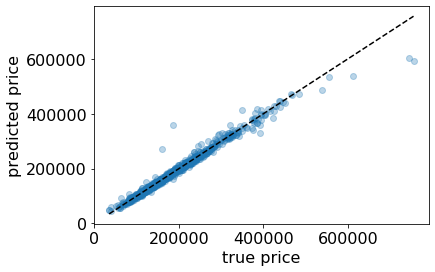

In [32]:
def scatter_results(regressor, X, y, alpha=0.3):
    plt.scatter(y, regressor.predict(X), alpha=alpha)
    grid = np.linspace(y.min(), y.max(), 1000)
    plt.plot(grid, grid, '--k');
    plt.xlabel("true price");
    plt.ylabel("predicted price");

scatter_results(lgbm, X_train, y_train)

- (First off, this looks way better that linear regression from last time)
- Notice how the points tend to fall on both sides of the line.
- When we create the regressor we can set it to quantile regression - watch this!

In [33]:
lgbm_90 = make_pipeline(preprocessing, LGBMRegressor(objective='quantile', alpha=0.9))

I apologize on behalf of the universe - this is a completely different `alpha` from the `Ridge(alpha=...)` 

In [34]:
lgbm_90.fit(X_train, y_train);

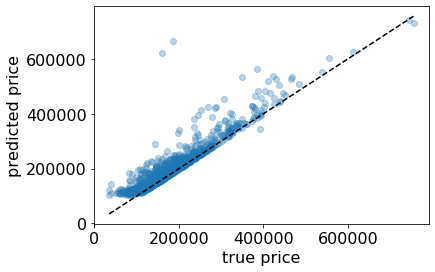

In [35]:
scatter_results(lgbm_90, X_train, y_train)

- This did what we asked! The true value is below the predicted value 90% of the time.
- Put another way, this made the predictions larger.
- Note the analogy to `class_weight` here!
  - We can "fudge" the predictions.
  - This is legitimately useful, it's not "wrong".
  - We were fudging `predict_proba` for classification and `predict` for regression.
  - Our reasons for doing this are very different though (class imbalance vs. wanting prediction intervals).

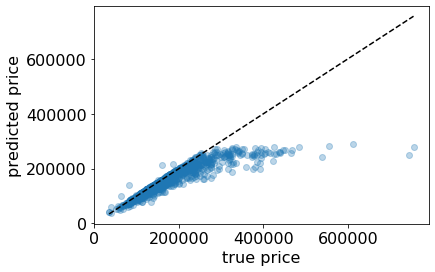

In [36]:
lgbm_10 = make_pipeline(preprocessing, LGBMRegressor(objective='quantile', alpha=0.1)).fit(X_train, y_train);
scatter_results(lgbm_10, X_train, y_train)

- Yikes, those are pretty hardcore changes here.
  - Outliers are complicated (see a later lecture).
- We can use `lgbm_90` and `lgbm_10` to get us prediction intervals.

In [37]:
X_test[:1]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
148,60,RL,NaN,9505,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


In [38]:
lgbm.predict(X_test[:1])

array([225147.06958953])

In [39]:
lgbm_10.predict(X_test[:1])

array([211248.39402167])

In [40]:
lgbm_90.predict(X_test[:1])

array([223954.89941099])

- This is a bit weird because our bounds are both below the prediction.
- To avoid this, we can use the 50% quantile as our prediction instead of the default (which is like the mean);

In [41]:
lgbm_50 = make_pipeline(preprocessing, LGBMRegressor(objective='quantile', alpha=0.5)).fit(X_train, y_train)

In [42]:
lgbm_50.predict(X_test[:1])

array([219877.12985757])

- There we go, our prediction is \\$222k, with a range from \\$211k to \\$224.5k .
- Note that the interval is not necessarily symmetric (error bar below is much larger than above)

Let's make some plots using our 3 models, on the first 20 test cases:

In [43]:
def plot_intervals(mid, low, hi, X, y):
    mid_pred = mid.predict(X)
    plt.plot(np.vstack((y, y)), np.vstack((low.predict(X), hi.predict(X))), 'b');

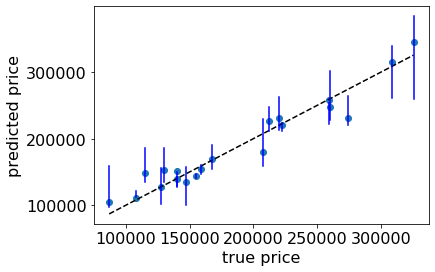

In [44]:
scatter_results(lgbm_50, X_test[:20], y_test[:20], alpha=1)
plot_intervals(lgbm_50, lgbm_10, lgbm_90, X_test[:20], y_test[:20])

- What do you think of the size of the errorbars? 
  - They look fairly reasonable to me. 
  - The truth is contained inside the errorbars most of the time.
  - The decision here is domain specific - again a human factor.
- But you could try smaller intervals using, say, 0.75 and 0.25 instead of 0.9 and 0.1:

In [45]:
lgbm_25 = make_pipeline(preprocessing, LGBMRegressor(objective='quantile', alpha=0.25)).fit(X_train, y_train);
lgbm_75 = make_pipeline(preprocessing, LGBMRegressor(objective='quantile', alpha=0.75)).fit(X_train, y_train);

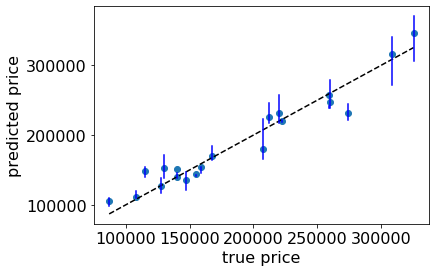

In [46]:
scatter_results(lgbm_50, X_test[:20], y_test[:20], alpha=1)
plot_intervals(lgbm_50, lgbm_25, lgbm_75, X_test[:20], y_test[:20])

## Break (5 min)

<br><br><br>

Reminder: resume recording

## Feature importances: linear regression (30 min)

- Like logistic regression, with linear regression we can look at the _coefficients_ for each feature.
- Overall idea: predicted price = intercept + $\sum_i$ coefficient i $\times$ feature i.
- Let's first train on the un-logged data, for simplicity:

In [47]:
lr = make_pipeline(preprocessing, Ridge())
lr.fit(X_train, y_train);

In [48]:
lr_coefs = pd.DataFrame(data=lr[1].coef_, index=new_columns, columns=["Coefficient"])
lr_coefs.head(30)

,Coefficient
LotFrontage,-1767.456662
LotArea,3729.004619
OverallQual,11339.337165
OverallCond,5202.941536
YearBuilt,3083.309848
YearRemodAdd,-485.725259
MasVnrArea,2882.726678
BsmtFinSF1,3656.124574
BsmtFinSF2,1323.411865
BsmtUnfSF,-1796.591359


In [49]:
lr[1].intercept_

-121873.05137512289

In [50]:
lr_coefs.loc[["PoolArea", "LotFrontage"]]

,Coefficient
PoolArea,6422.128946
LotFrontage,-1767.456662


Intuition: 

- **Increasing** `PoolArea` by 1 scaled unit **increases** the predicted price by $\sim\$6400$.
- **Increasing** `LotFrontage` by 1 scaled unit **decreases** the predicted price by $\sim\$1800$.

Does that seem reasonable?

- For `PoolArea`, yes. 
- For `LotFrontage`, that's surprising - I expected something positive.
- Do we believe these interpretations??
  - Do we believe this is how the predictions are being computed? Yes.
  - Do we believe that this is how the world works? No. 
  - For more info, take STAT 306.

As an example, maybe the problem is that `LotFrontage` and `LotArea` are very correlated. `LotArea` has a larger positive coefficient. So maybe the overall interpretation is that big lots are good, but narrower lots (small frontage) are also good. This is probably not correct either! But it's an example of the ambiguities here. 

In [51]:
import seaborn as sns

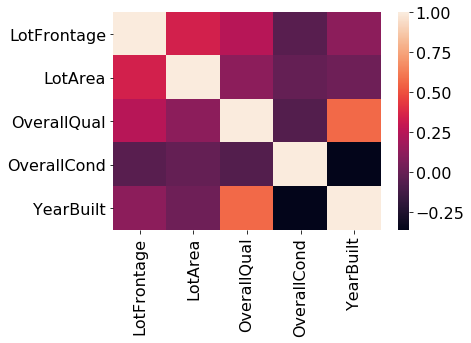

In [52]:
sns.heatmap(X_train_enc[numeric_features[:5]].corr());

BTW, let's make sure the predictions behave as expected:

In [53]:
one_example = X_test[:1]

In [54]:
one_example

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
148,60,RL,NaN,9505,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


In [55]:
lr.predict(one_example)

array([222545.43672749])

In [56]:
one_example_perturbed = one_example.copy()
one_example_perturbed["LotArea"] += 1 # add 1 to the LotArea

In [57]:
one_example_perturbed

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
148,60,RL,NaN,9506,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


In [58]:
lr.predict(one_example_perturbed)

array([222545.82613608])

In [59]:
lr.predict(one_example_perturbed) - lr.predict(one_example)

array([0.38940859])

In [60]:
lr_coefs.loc[["LotArea"]]

,Coefficient
LotArea,3729.004619


- Why did the prediction only go up by \\$0.39 instead of \\$3729? 

<br><br><br>

- This is an issue of units. `LotArea` is in sqft, but the coefficient is not $\$3729/\text{sqft}$ **because we scaled the features**. 

In [61]:
scaler = preprocessing.named_transformers_['numeric']['standardscaler']

- The scaler subtracted the mean and divided by the standard deviation.
- For the unit conversion, we don't care about the subtraction, but only the scaling.

In [62]:
np.sqrt(scaler.var_)

array([2.13745654e+01, 9.57607182e+03, 1.40580964e+00, 1.13370232e+00,
       3.05509964e+01, 2.06956049e+01, 1.78076438e+02, 4.66876060e+02,
       1.66176985e+02, 4.41525194e+02, 4.50155639e+02, 3.96458799e+02,
       4.36894658e+02, 4.96007198e+01, 5.40091680e+02, 5.18546179e-01,
       2.28010762e-01, 5.52851701e-01, 5.05102919e-01, 1.64938080e+00,
       6.36310176e-01, 2.43294905e+01, 7.47247404e-01, 2.11907054e+02,
       1.28562065e+02, 6.60750501e+01, 6.04084478e+01, 2.71546081e+01,
       5.60163794e+01, 4.29887479e+01, 3.00279273e+02, 1.33190203e+00])

In [63]:
lr_scales = pd.DataFrame(data=np.sqrt(scaler.var_), index=numeric_features, columns=["Scale"])
lr_scales

,Scale
LotFrontage,21.374565
LotArea,9576.071818
OverallQual,1.405810
OverallCond,1.133702
YearBuilt,30.550996
YearRemodAdd,20.695605
MasVnrArea,178.076438
BsmtFinSF1,466.876060
BsmtFinSF2,166.176985
BsmtUnfSF,441.525194


In [64]:
X_train["LotArea"].std();

In [65]:
lr_coefs.loc["LotArea","Coefficient"]

3729.00461925854

In [66]:
lr_scales.loc["LotArea","Scale"]

9576.071817790295

In [67]:
lr_coefs.loc["LotArea","Coefficient"]/lr_scales.loc["LotArea","Scale"]

0.38940858947307044

- It seems like `PoolArea` was divided by 43 sqft. 
- So $3729 \; \text{\$/unit} \times \frac{1 \text{unit}}{43 \text{sqft}} \approx 149 \; \text{\$/sqft}$

In [68]:
lr_coefs.loc["PoolArea","Coefficient"]/lr_scales.loc["PoolArea","Scale"]

149.39092800873365

- That makes a bit more sense!
  - (But, again, don't read too much into this number without statistical training!)
- Note: we can get the same result using the scaler's `inverse_transform` function:

In [69]:
delta = scaler.inverse_transform(np.ones(len(numeric_features))) - scaler.inverse_transform(np.zeros(len(numeric_features)))
lr_scales2 = pd.DataFrame(data=delta, index=numeric_features, columns=["Scale"])
lr_scales2.tail()

,Scale
3SsnPorch,27.154608
ScreenPorch,56.016379
PoolArea,42.988748
MiscVal,300.279273
YrSold,1.331902


- Actually `inverse_transform` is nicer in a way, because it generalized to any sort of scaler/normalizer you're using.

- What about the categorical features?
- We didn't scale these, so we can interpret the coefficients without this concern.
- The ordinal features are easiest:

In [70]:
print(ordinal_features_reg)

['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']


In [71]:
lr_coefs.loc["ExterQual", 'Coefficient']

5941.941090670965

- "Increasing by one category of exterior quality (e.g. good -> excellent) increases the predicted price by \\$5942".
  - Wow, that's a lot! 

- The OHE features are a bit more of a hassle.

In [72]:
print(categorical_features)

['BldgType', 'Condition1', 'KitchenAbvGr', 'HouseStyle', 'RoofStyle', 'SaleCondition', 'MSSubClass', 'RoofMatl', 'LandSlope', 'Heating', 'LandContour', 'Exterior1st', 'LotShape', 'Foundation', 'Exterior2nd', 'MSZoning', 'BsmtFinType2', 'MasVnrType', 'CentralAir', 'GarageFinish', 'MoSold', 'MiscFeature', 'PavedDrive', 'BsmtExposure', 'LotConfig', 'Neighborhood', 'BedroomAbvGr', 'GarageType', 'Condition2', 'SaleType', 'Fence', 'BsmtFinType1', 'Utilities', 'Functional', 'Street', 'Electrical', 'Alley']


In [73]:
lr_coefs_landslope = lr_coefs[lr_coefs.index.str.startswith("LandSlope")]
lr_coefs_landslope

,Coefficient
LandSlope_Gtl,-6474.202721
LandSlope_Mod,7138.195339
LandSlope_Sev,-663.992618


- We can talk about switching from one of these categories to another by picking a "reference" category:

In [74]:
lr_coefs_landslope - lr_coefs_landslope.loc["LandSlope_Gtl"]

,Coefficient
LandSlope_Gtl,0.000000
LandSlope_Mod,13612.398061
LandSlope_Sev,5810.210103


Be a bit careful here:

- If you did `drop='first'` (we didn't) then you already have a reference class, and all the values are with respect to that one.
- The interpretation depends on whether we did `drop='first'`, hence the hassle.

Let's sort the coefficients:

In [75]:
lr_coefs.sort_values(by="Coefficient")

,Coefficient
RoofMatl_ClyTile,-176003.848493
Condition2_PosN,-98557.151215
Heating_OthW,-24564.135444
MSZoning_C (all),-21587.735117
BedroomAbvGr_5,-20582.490457
...,...
Exterior2nd_ImStucc,36710.313710
RoofMatl_CompShg,38863.951982
Condition2_PosA,39891.544500
Neighborhood_NridgHt,45871.062263


- "If the roof is made of clay or tile, the predicted price is \\$176k less" ?
- That is a huge amount!

In [76]:
lr_coefs_landslope = lr_coefs[lr_coefs.index.str.startswith("RoofMatl")]
lr_coefs_landslope

,Coefficient
RoofMatl_ClyTile,-176003.848493
RoofMatl_CompShg,38863.951982
RoofMatl_Membran,24572.916813
RoofMatl_Roll,11793.038384
RoofMatl_Tar&Grv,3443.806372
RoofMatl_WdShake,13372.109410
RoofMatl_WdShngl,83958.025531


- Note to self: stay away from clay or tile.
- Or, wait, can we actually believe that?
  - Without further training: no.

#### Interpretation in log space

- If we log-transform the targets then the interpretation changes.

In [77]:
lr_log = make_pipeline(preprocessing, Ridge())
lr_log.fit(X_train, np.log(y_train));

In [78]:
lr_log_coefs = pd.DataFrame(data=lr_log[1].coef_, index=new_columns, columns=["Coefficient"])
lr_log_coefs.loc[["LotArea", "LotFrontage"]]

,Coefficient
LotArea,0.013140
LotFrontage,-0.002005


- We keep the intuition that positive coefficients make the predicted price go up, negative coefficients make it go down.
- If we increase `LotArea` by 1 scaled unit, then we increase the **log** predicted price by 0.013.
- What does it mean to increase the log of something by $x$?

log(new) = log(old) + $x$

Take exp of both sides:

new = old  $\times \exp(x)$

So, increasing `LotArea` by 1 scaled unit means we _multiply_ the predicted price by $\exp(0.013)$:

In [79]:
np.exp(lr_log_coefs.loc["LotArea", "Coefficient"])

1.013226277022084

And, increasing `LotFrontage` by 1 scaled unit means we _multiply_ the predicted price by $\exp(-0.002)$:

In [80]:
np.exp(lr_log_coefs.loc["LotFrontage", "Coefficient"])

0.9979965338275385

(Advanced note) For those familiar with Taylor expansions, you will know that when $x$ is small then $\exp(x)\approx 1+x$, which is what you're seeing here. But in general we might have big coefficients and this approximation is not helpful to think about.

Let's test this out!

In [81]:
one_example = X_test[:1]

In [82]:
np.exp(lr_log.predict(one_example))

array([216017.19888138])

In [83]:
lr_scales.loc["LotArea","Scale"]

9576.071817790295

In [84]:
one_example_perturbed = one_example.copy()
one_example_perturbed["LotArea"] += lr_scales.loc["LotArea","Scale"] # add 1 to the scaled LotArea

In [85]:
np.exp(lr_log.predict(one_example_perturbed))

array([218874.30219532])

In [86]:
np.exp(lr_log.predict(one_example_perturbed)) / np.exp(lr_log.predict(one_example))

array([1.01322628])

- So we can say something like, "Increasing the lot area by ~10,000 sq ft causes the predicted price to go up by around 1.3%".
- Again, I am being careful to say "predicted price" instead of price, because we're just talking about our model, not the world.

## Feature importances: beyond linear models (20 min)

#### Why model interpretability? 

- Ability to interpret ML models is crucial in many applications such as banking, healthcare, and criminal justice.
- It can be leveraged by domain experts to diagnose systematic errors and underlying biases of complex ML systems. 
- One problem is that often simple models are interpretable but not accurate.
- But more complex models, like random forests, are less interpretable.
- In this course, our definition of model iterpretability will be looking at feature importances.
- There is more to interpretability than feature importances, but it's a good start!

#### Model interpretability 

We will be looking at two ways of getting feature importances for non-linear models. 
  - sklearn `feature_importances_`
  - [SHAP](https://github.com/slundberg/shap)

In [87]:
rf = make_pipeline(preprocessing, RandomForestRegressor(random_state=111))
rf.fit(X_train, np.log(y_train));

In [88]:
rf_importances = pd.DataFrame(data=rf[1].feature_importances_, index=new_columns, columns=["Importance"])
rf_importances.sort_values(by="Importance", ascending=False).head()

,Importance
OverallQual,0.544057
GrLivArea,0.109479
TotalBsmtSF,0.052421
GarageCars,0.049012
1stFlrSF,0.023216


- Unlike the linear model coefficients, `feature_importances_` do not have a sign!
  - They tell us about importance, but not an "up or down".
  - Indeed, increasing a feature may cause the prediction to first go up, and then go down.
  - This cannot happen in linear models, because they are linear.
  - ^ This is a key point!!
- We could compare with the absolute value of the coefficients from Ridge:

In [89]:
lr_tuned_log = make_pipeline(preprocessing, Ridge(alpha=100))
lr_tuned_log.fit(X_train, np.log(y_train));

In [90]:
lr_tuned_log_coefs = pd.DataFrame(data=lr_tuned_log[1].coef_, index=new_columns, columns=["Coefficient"])
lr_tuned_log_coefs.abs().sort_values(by="Coefficient", ascending=False).head()

,Coefficient
OverallQual,0.079477
GarageCars,0.044766
GrLivArea,0.043596
OverallCond,0.040942
BsmtQual,0.035982


- Both models agree that overall quality is by far the most important feature (makes sense!).
- Note: we should not be comparing the actual numbers, e.g. 0.5 from random forest vs. 0.08 from linear regression.

- These values tell us globally about which features are important.
- But what if you want to explain a _specific_ prediction. 
- Some fancier tools can help us do this.

#### SHAP  (SHapley Additive exPlanations)

- A sophisticated measure of the contribution of each feature.
- For more detail, see [GitHub repo](https://github.com/slundberg/shap) and [paper](https://arxiv.org/pdf/1705.07874.pdf).
- We won't go in details. You may refer to  if you are interested to know more. 

In [91]:
explainer = shap.TreeExplainer(rf[1])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


- For both the linear regression coefficients and the random forest feature importances, these were the features _after preprocessing_.
- We'll continue to do that below.

In [92]:
X_train_enc = pd.DataFrame(preprocessing.transform(X_train), index=X_train.index, columns=new_columns)

In [93]:
X_train_enc.shape

(1095, 292)

We'll compute the SHAP values on the training set (but could do it for other data):

In [94]:
shap_values = explainer.shap_values(X_train_enc) # this takes a couple minutes

This is just a numpy array:

In [95]:
shap_values.shape

(1095, 292)

In [96]:
shap.initjs()

In [97]:
X_train_enc.head(1)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Street_Pave,Electrical_?,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Alley_?,Alley_Grvl,Alley_Pave
Id,,,,,,,,,,,,,,,,,,,,,
1447,-0.046315,1.6544,-0.775646,1.255836,-0.282035,-1.105566,0.491436,0.32743,-0.28498,0.064219,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [98]:
rf[1].predict(X_train_enc)[0]

11.94633015451298

In [99]:
shap.force_plot(explainer.expected_value, shap_values[0], X_train_enc.iloc[0])

In [100]:
# shap.force_plot(explainer.expected_value, shap_values[0], X_train_enc.iloc[0], matplotlib=True)

Above: for this particular training example, we can see the main factors pushing it from the base value (average over the dataset) to this particular prediction. 

Note: a nice thing about SHAP values is that the feature importances sum to the prediction:

In [101]:
rf[1].predict(X_train_enc)[0]

11.94633015451298

In [102]:
shap_values[0].sum() + explainer.expected_value

11.946330154512983

This is the case for classification as well, but for the "raw model output" rather than the probability itself, because the SHAP values do not necessarily sum to something between 0 and 1.

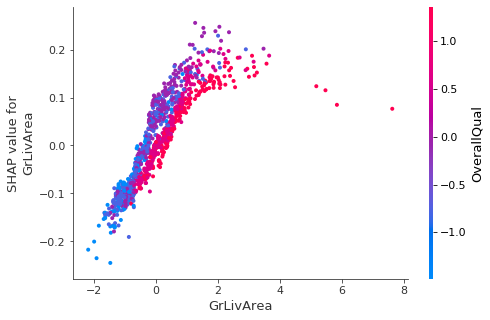

In [103]:
shap.dependence_plot("GrLivArea", shap_values, X_train_enc)

- When `GrLivArea` (above grade living area) increases, the shap value also increases -> that makes sense.
- But this type of plot also allows us to visualize non-linear or even non-monotonic behaviours.
- Note: shap automatically selects another feature -- in this case `OverallQual` -- for colouring.

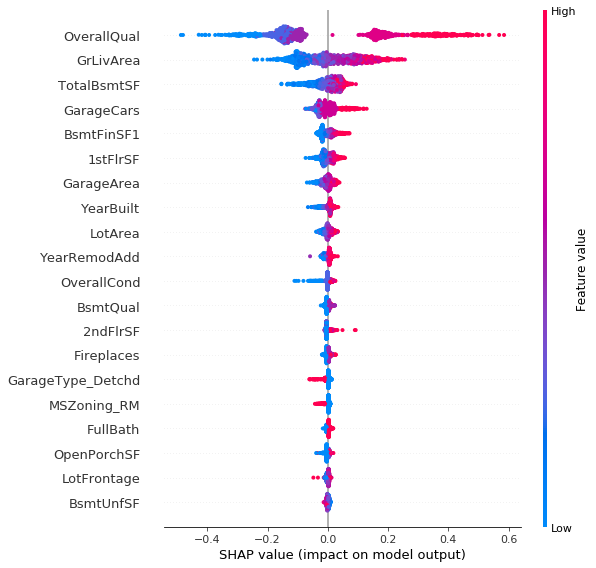

In [104]:
shap.summary_plot(shap_values, X_train_enc)

- This plot orders features by importance (average SHAP value magnitude).
- Each example is drawn.
- We can see again that the prediction is higher when `OverallQual` is higher.
- There's also a summary of the summary:

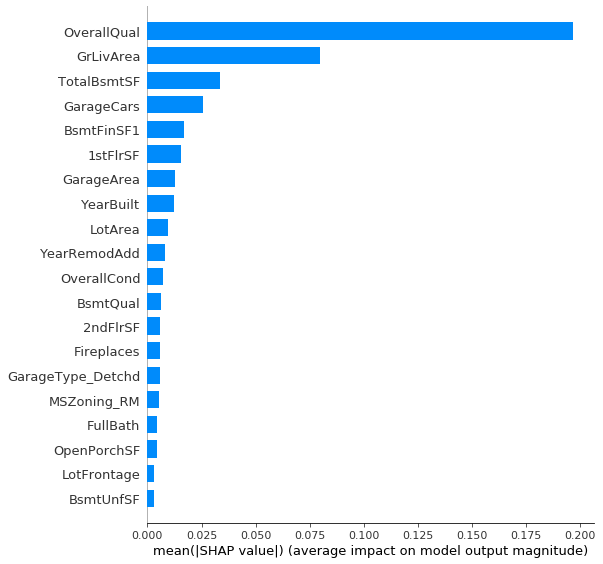

In [105]:
shap.summary_plot(shap_values, X_train_enc, plot_type="bar")

Going back to the `feature_importances_`, we see something similar:

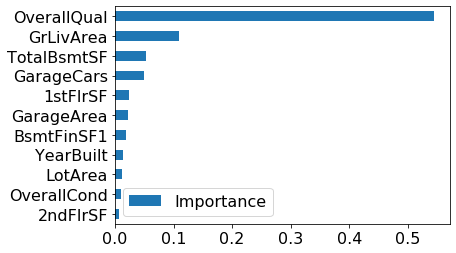

In [106]:
rf_importances.sort_values(by="Importance", ascending=False)[10::-1].plot.barh();

(Note: pandas has some built-in rudimentary plotting functionalities, which are quite convenient at times.) 

#### Other tools

- [ELI5](https://github.com/TeamHG-Memex/eli5) is another related package.
- [lime](https://github.com/marcotcr/lime) is yet another.

If you're not already impressed, keep in mind:

- So far we've only used sklearn models.
- Most sklearn models have some built-in measure of feature importances.
- On many tasks we need to move beyond sklearn, e.g. LightGBM, deep learning.
  - Not sure yet how much of that we'll do in this course.
- These tools work on other models as well, which makes them extremely useful.

#### Why do we want this information?

Possible reasons:

- Identify features that are not useful and maybe remove them.
- Get guidance on what new data to collect.
  - New features related to useful features -> better results.
  - Don't bother collecting useless features -> save resources.
- Help explain why the model is making certain predictions. 
  - Debugging, if the model is behaving strangely.
  - Regulatory requirements.
  - Fairness / bias.
  - Keep in mind this can be use on **deployment** predictions!
- And more...

## Summary

- Ensemble methods can be used for regression as well
  - Averaging now takes the mean instead of voting
  - Stacking uses linear regression as the meta-model by default (instead of logistic regression)
- Prediction intervals are useful for communicating uncertainty
  - We will generate them using quantile regression where available in the software packages we're using
  - We won't interpret the quantiles formally or draw statistical conclusions
- Like `LogisticRegression`, we have interpretable coefficients in `Ridge`
  - Positive means increasing that feature leads to a larger prediction, vice versa for negative
  - The interpretation requires un-scaling for numeric features, a bit easier for categorical features
  - Relationships are not causal!
- SHAP is an awesome tool for model interpretability
  - It gives signed (pos or neg) feature importances
  - Also allows us to explore a particular prediction, even on test data

## Feature importances True/False

Part 1:

1. With linear regression, if the first coefficient is 5, that means increasing your first feature by 1 increases the prediction by 5.
1. With linear models, increasing a feature value always impacts the prediction in the same direction; with other models, this may not be the case.
2. Since the `PoolArea` has a positive coefficient, expanding my pool will get me a higher price when I sell my house.

Part 2:

1. scikit-learn's feature importances only pertain to the training data. 
2. SHAP values only pertain to the training data.
3. Based on the plot below, newer houses tend to cost more than older houses.
4. Based on the plot below, age is less important for higher quality houses than for lower quality houses.  

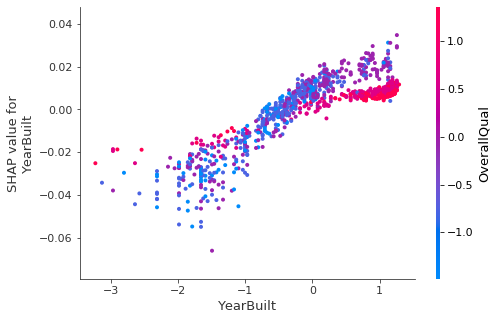

In [107]:
shap.dependence_plot("YearBuilt", shap_values, X_train_enc)